# Solar Power Energy Prediction - Model Training and Evaluation
## Phase 3: Modeling (Following Preprocessing Phase)

**Prerequisites:** preprocessing.ipynb must be completed first

## 3.1 Data Preparation

### 3.1.1 Import Libraries

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### 3.1.2 Load Feature Engineered Data

In [28]:
# Load the feature engineered dataset
data = pd.read_csv("../data/solarpowergeneration_cleaned.csv")
print(f"Data loaded: {data.shape}")
print(f"Columns: {data.shape[1]}")
print(f"Rows: {data.shape[0]}")
data.head()

Data loaded: (2906, 10)
Columns: 10
Rows: 2906


,distance-to-solar-noon,temperature,wind-speed,sky-cover,humidity,average-wind-speed-(period),average-pressure-(period),power-generated,wind_dir_sin,wind_dir_cos
0,0.859897,69,7.5,0,75,8.0,29.82,0,-1.0,-1.836970e-16
1,0.628535,69,7.5,0,77,5.0,29.85,0,-1.0,-1.836970e-16
2,0.397172,69,7.5,0,70,0.0,29.89,5418,-1.0,-1.836970e-16
3,0.165810,69,7.5,0,33,0.0,29.91,25477,-1.0,-1.836970e-16
4,0.065553,69,7.5,0,21,3.0,29.89,30069,-1.0,-1.836970e-16


In [29]:
data.sample(5)

,distance-to-solar-noon,temperature,wind-speed,sky-cover,humidity,average-wind-speed-(period),average-pressure-(period),power-generated,wind_dir_sin,wind_dir_cos
2019,0.571765,58,16.6,1,74,8.0,30.02,0,-0.984808,-1.736482e-01
2046,0.063158,71,6.4,0,58,3.0,29.86,31322,-0.939693,3.420201e-01
1787,0.621039,50,26.6,2,61,16.0,29.96,0,-0.984808,1.736482e-01
279,0.863702,65,11.1,2,87,14.0,30.03,0,-1.000000,-1.836970e-16
908,0.122164,51,10.4,4,80,7.0,29.84,2014,0.766044,-6.427876e-01


In [30]:
data.columns

Index(['distance-to-solar-noon', 'temperature', 'wind-speed', 'sky-cover', 'humidity', 'average-wind-speed-(period)', 'average-pressure-(period)', 'power-generated', 'wind_dir_sin', 'wind_dir_cos'], dtype='object')

In [31]:
# Check data types and missing values
print("\nData Info:")
print("="*60)
print(f"Missing values: {data.isna().sum().sum()}")
print(f"Duplicate rows: {data.duplicated().sum()}")


Data Info:
Missing values: 0
Duplicate rows: 0


### 3.1.3 Train-Test Split

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
# Separate features (X) and target (y)
X = data.drop('power-generated', axis=1)
y = data['power-generated']

# Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1.4 Feature Scaling

In [33]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

robust_cols = [
    'wind-speed',
    'humidity',
    'average-wind-speed-(period)'
]

standard_cols = [
    'distance-to-solar-noon',
    'temperature'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_cols),
        ('standard', StandardScaler(), standard_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False   # 🔑 removes prefixes
)

# Fit scaler ONLY on Training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform Test data (Do NOT fit)
X_test_scaled = preprocessor.transform(X_test)


In [34]:
y_train_log = np.log1p(y_train)  # Apply log1p to training target
y_test_log = np.log1p(y_test)

In [35]:
X_train_scaled.shape

(2324, 9)

In [36]:
y_train_log.shape

(2324,)

## 3.2 Model Building

## 3.2.1 Linear Models

### 3.2.1.1 LINEAR REGRESSION (OLS – Baseline)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize Linear Regression
lr_model = LinearRegression(fit_intercept=True, n_jobs=-1)

# Fit
lr_model.fit(X_train_scaled, y_train_log)

y_train_pred_lr_log = lr_model.predict(X_train_scaled)
y_test_pred_lr_log = lr_model.predict(X_test_scaled)

y_train_pred_lr = np.expm1(y_train_pred_lr_log)
y_test_pred_lr = np.expm1(y_test_pred_lr_log)
# Metrics
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
r2_train_lr = r2_score(y_train, y_train_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

results = {} # Model Evalution Metrics Dictionary
results["LinearRegression"] = {
"Train MAE" : mae_train_lr,
"Test MAE"  : mae_test_lr,
"Train RMSE": rmse_train_lr,
"Test RMSE" : rmse_test_lr,
"Train R²" : r2_train_lr,
"Test R²" : r2_test_lr,
}

print("="*60)
print("LINEAR REGRESSION (OLS) – FINAL PERFORMANCE")
print("="*60)
print(f"Train MAE : {mae_train_lr:.4f}")
print(f"Test MAE : {mae_test_lr:.4f}")
print(f"Train RMSE : {rmse_train_lr:.4f}")
print(f"Test RMSE : {rmse_test_lr:.4f}")
print(f"Train R² : {r2_train_lr:.4f}")
print(f"Test R² : {r2_test_lr:.4f}")


LINEAR REGRESSION (OLS) – FINAL PERFORMANCE
Train MAE : 6838.1735
Test MAE : 7706.6942
Train RMSE : 17858.3100
Test RMSE : 22461.1066
Train R² : -1.9962
Test R² : -3.7081


### 3.2.1.2 RIDGE REGRESSION (L2 REGULARIZATION)

In [38]:
from sklearn.linear_model import Ridge

# Initialize Ridge
ridge_model = Ridge(random_state=42)

# Hyperparameter grid
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 50.0]
}

# GridSearchCV
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search_ridge.fit(X_train_scaled, y_train_log)

# Best model
best_ridge_model = grid_search_ridge.best_estimator_

# Predictions
y_train_pred_ridge_log = best_ridge_model.predict(X_train_scaled)
y_test_pred_ridge_log = best_ridge_model.predict(X_test_scaled)

y_train_pred_ridge = np.expm1(y_train_pred_ridge_log)
y_test_pred_ridge = np.expm1(y_test_pred_ridge_log)

# Metrics
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

results["Ridge"] = {
"Train MAE" : mae_train_ridge,
"Test MAE"  : mae_test_ridge,
"Train RMSE": rmse_train_ridge,
"Test RMSE" : rmse_test_ridge,
"Train R²" : r2_train_ridge,
"Test R²" : r2_test_ridge,
}

print("="*60)
print("RIDGE REGRESSION – FINAL PERFORMANCE")
print("="*60)
print(f"Train MAE : {mae_train_ridge:.4f}")
print(f"Test MAE : {mae_test_ridge:.4f}")
print(f"Train RMSE : {rmse_train_ridge:.4f}")
print(f"Test RMSE : {rmse_test_ridge:.4f}")
print(f"Train R² : {r2_train_ridge:.4f}")
print(f"Test R² : {r2_test_ridge:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
RIDGE REGRESSION – FINAL PERFORMANCE
Train MAE : 6836.5076
Test MAE : 7705.5514
Train RMSE : 17851.7862
Test RMSE : 22457.1813
Train R² : -1.9940
Test R² : -3.7065


### 3.2.1.3 LASSO REGRESSION (L1 REGULARIZATION)

In [39]:
from sklearn.linear_model import Lasso

# Initialize Lasso
lasso_model = Lasso(max_iter=5000, random_state=42)

# Hyperparameter grid
param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# GridSearchCV
grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid_lasso,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search_lasso.fit(X_train_scaled, y_train_log)

# Best model
best_lasso_model = grid_search_lasso.best_estimator_

# Predictions
y_train_pred_lasso_log = best_lasso_model.predict(X_train_scaled)
y_test_pred_lasso_log = best_lasso_model.predict(X_test_scaled)

y_train_pred_lasso = np.expm1(y_train_pred_lasso_log)
y_test_pred_lasso = np.expm1(y_test_pred_lasso_log)

# Metrics
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

results["Lasso"] = {
"Train MAE" : mae_train_lasso,
"Test MAE"  : mae_test_lasso,
"Train RMSE": rmse_train_lasso,
"Test RMSE" : rmse_test_lasso,
"Train R²" : r2_train_lasso,
"Test R²" : r2_test_lasso,
}

print("="*60)
print("LASSO REGRESSION – FINAL PERFORMANCE")
print("="*60)
print(f"Train MAE : {mae_train_lasso:.4f}")
print(f"Test MAE : {mae_test_lasso:.4f}")
print(f"Train RMSE : {rmse_train_lasso:.4f}")
print(f"Test RMSE : {rmse_test_lasso:.4f}")
print(f"Train R² : {r2_train_lasso:.4f}")
print(f"Test R² : {r2_test_lasso:.4f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
LASSO REGRESSION – FINAL PERFORMANCE
Train MAE : 6835.0192
Test MAE : 7705.0323
Train RMSE : 17843.5050
Test RMSE : 22454.3472
Train R² : -1.9912
Test R² : -3.7053


**Linear model performance summary:**
All linear models (OLS, Ridge, and Lasso) perform poorly on this task, with very high MAE/RMSE values and strongly negative R² scores on both training and test sets. The similar errors across models indicate that regularization (Ridge/Lasso) provides no meaningful improvement over plain linear regression, suggesting the underlying relationship is not well captured by a linear model and that the models are underfitting the data.


## 3.2.2 Kernel-Based Models


### 3.2.2.1 Support Vector Regression (SVR) - can capture nonlinear patterns using kernels

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np


In [41]:
y_log = np.log1p(y)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [42]:
# PCA
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.36149878 0.22133863 0.13831266 0.12399102 0.06313664]
Total variance explained: 0.908277730842544


In [43]:
from sklearn.svm import SVR
svr = SVR(
    kernel='rbf',
    C=100,
    gamma='scale',
    epsilon=0.1
)

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train
svr.fit(X_train_pca, y_train_log)

# Predict (log scale)
train_pred_log = svr.predict(X_train_pca)
test_pred_log = svr.predict(X_test_pca)

# Convert back to original scale
train_pred = np.expm1(train_pred_log)
test_pred = np.expm1(test_pred_log)

y_train_orig = np.expm1(y_train_log)
y_test_orig = np.expm1(y_test_log)

print("SVR Performance")
print("="*30)
print("Train MAE:", mean_absolute_error(y_train_orig, train_pred))
print("Test  MAE:", mean_absolute_error(y_test_orig, test_pred))
print("Test  RMSE:", mean_squared_error(y_test_orig, test_pred))
print("Test  R²:", r2_score(y_test_orig, test_pred))


SVR Performance
Train MAE: 1591.7529324890606
Test  MAE: 2991.496904194018
Test  RMSE: 61869120.97972922
Test  R²: 0.42262551395128567


### Hyperparameter tuning of Support Vector Regressor

Performing hyperparameter tuning to optimize the SVR Model.

In [45]:
## Hyper parameter tuning

from sklearn.model_selection import GridSearchCV

# Base SVR
svr = SVR(kernel='rbf')


param_grid = {
    'C': [200,500],
    'epsilon': [0.001, 0.01, 0.05],
    'gamma': ['scale', 0.1, 0.01] 
}

svr_grid = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3, 
    n_jobs=-1,
    verbose=2
)

svr_grid.fit(X_train_pca, y_train_log)

print("Best Parameters:", svr_grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'C': 200, 'epsilon': 0.05, 'gamma': 'scale'}


In [46]:
best_svr = svr_grid.best_estimator_

y_train_pred_svr_log = best_svr.predict(X_train_pca)
y_test_pred_svr_log = best_svr.predict(X_test_pca)

y_train_pred = np.expm1(y_train_pred_svr_log)
y_test_pred = np.expm1(y_test_pred_svr_log)

mae_train_svr = mean_absolute_error(y_train, y_train_pred) 
mae_test_svr = mean_absolute_error(y_test, y_test_pred)  

rmse_train_svr = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train_svr = r2_score(y_train, y_train_pred)
r2_test_svr = r2_score(y_test, y_test_pred)

results["SVR"] = {
"Train MAE" : mae_train_svr,
"Test MAE"  : mae_test_svr,
"Train RMSE": rmse_train_svr,
"Test RMSE" : rmse_test_svr,
"Train R²" : r2_train_svr,
"Test R²" : r2_test_svr,
}

print("SVR Performance (Tuned Model):")
print("\n[ Original-Scale Metrics ]")
print(f"Train MAE : {mae_train_svr:.4f}")
print(f"Test MAE : {mae_test_svr:.4f}")
print(f"Train RMSE : {rmse_train_svr:.4f}")
print(f"Test RMSE : {rmse_test_svr:.4f}")
print(f"Train R² : {r2_train_svr:.4f}")
print(f"Test R² : {r2_test_svr:.4f}")


SVR Performance (Tuned Model):

[ Original-Scale Metrics ]
Train MAE : 1470.0952
Test MAE : 3105.0298
Train RMSE : 3281.2238
Test RMSE : 8677.6628
Train R² : 0.8989
Test R² : 0.2973


**Kernel-based SVR performance summary:**  
Although the tuned RBF-kernel SVR significantly improves over linear models, its test performance remains limited (R² ≈ 0.30) with a large gap between training and testing errors, indicating overfitting and insufficient generalization. Overall, SVR is still inadequate for this problem, motivating the use of more flexible tree-based models to better capture complex feature interactions.


## 3.2.3 Tree-Based Models

## 3.2.3.1 Decision Tree

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the Decision Tree Regressor on Train dataset
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)  
mae_test = mean_absolute_error(y_test, y_test_pred) 

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)


print("Decison Tree REGRESSION:")
print("\n[ Original-Scale Metrics ]")
print(f"Train MAE : {mae_train:.4f}")
print(f"Test MAE : {mae_test:.4f}")
print(f"Train RMSE : {rmse_train:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")


Decison Tree REGRESSION:

[ Original-Scale Metrics ]
Train MAE : 0.0000
Test MAE : 2215.0103
Train RMSE : 0.0000
Test RMSE : 4919.6374
Train R² : 1.0000
Test R² : 0.7741


### Hyperparameter tuning of Decision Tree

Performing hyperparameter tuning to optimize the Decision Tree Model.

In [48]:
# Base Decision Tree model
dt = DecisionTreeRegressor(random_state=42)


# Define the hyperparameter grid to search
# Key hyperparameters for regression include max_depth, min_samples_split, min_samples_leaf, and criterion
param_grid = {'max_depth': [5, 10, 20, 25],
              'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 2, 5, 10],
              'criterion': ['squared_error', 'absolute_error', 'poisson']}


# Grid Search
grid_search_dt = GridSearchCV(estimator=dt,
                              param_grid=param_grid,
                              cv=3,
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1,
                              verbose=1)


# Fit the GridSearchCV to the training data
print("Starting GridSearchCV...")
grid_search_dt.fit(X_train, y_train)

# Get the best parameters and best estimator
print(f"\nBest parameters found: {grid_search_dt.best_params_}")

Starting GridSearchCV...
Fitting 3 folds for each of 192 candidates, totalling 576 fits

Best parameters found: {'criterion': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}


In [49]:
#If fine-tuning is time-consuming, do not perform it. 
# Instead, comment out grid_search_dt.best_estimator_ (for all models) and load the pre-trained models in the final cell.
best_dt = grid_search_dt.best_estimator_   
print(f"\nBest estimator: {best_dt}")


Best estimator: DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      min_samples_leaf=5, min_samples_split=20,
                      random_state=42)


In [50]:

y_train_pred = best_dt.predict(X_train)
y_test_pred = best_dt.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)  
mae_test = mean_absolute_error(y_test, y_test_pred)  

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

results["Decison_Tree"] = {
"Train MAE" : mae_train,
"Test MAE"  : mae_test,
"Train RMSE": rmse_train,
"Test RMSE" : rmse_test,
"Train R²" : r2_train,
"Test R²" : r2_test,
}

print("Decison Tree Regresoor (Tuned Model):")
print(f"Train MAE : {mae_train:.4f}")
print(f"Test MAE : {mae_test:.4f}")
print(f"Train RMSE : {rmse_train:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")

Decison Tree Regresoor (Tuned Model):
Train MAE : 990.3386
Test MAE : 1791.0180
Train RMSE : 2566.4267
Test RMSE : 4038.0148
Train R² : 0.9381
Test R² : 0.8478


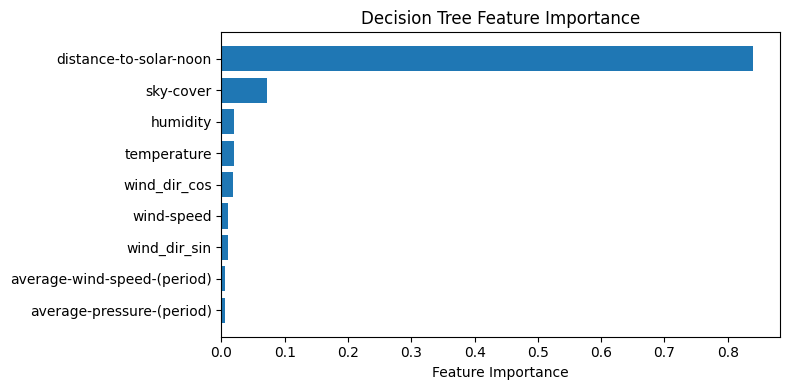

In [ ]:
# Plotting Feature Importance according to Decision Tree
importances_dt = best_dt.feature_importances_
feature_names = X_train.columns

feat_imp_dt = pd.DataFrame({"Feature": feature_names,
                            "Importance": importances_dt}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(feat_imp_dt["Feature"], feat_imp_dt["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.show()


## 3.2.3.2 Random Forest

In [52]:
# Initialize and fit the Random Forest Regressor on Train dataset
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred) 
mae_test = mean_absolute_error(y_test, y_test_pred)  

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Random Forest Regressor:")
print("="*30)
print(f"Train MAE : {mae_train:.4f}")
print(f"Test MAE : {mae_test:.4f}")
print(f"Train RMSE : {rmse_train:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")


Random Forest Regressor:
Train MAE : 486.6698
Test MAE : 1603.6151
Train RMSE : 1049.9409
Test RMSE : 3631.4454
Train R² : 0.9896
Test R² : 0.8769


### Hyperparameter tuning of Random Forest

Performing hyperparameter tuning to optimize the Random Forest Model.

In [53]:
#base random forest
rf = RandomForestRegressor(
    criterion='absolute_error',  
    random_state=42, 
    n_jobs=-1
)

param_grid = {
    'max_features': [1.0, 'sqrt'], 
    'max_depth': [15, 20],
    'min_samples_leaf': [2, 5],
    'n_estimators': [200, 300]
}

# Grid Search
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid,
                              cv=3,
                              scoring="neg_mean_absolute_error", 
                              n_jobs=-1,
                              verbose=1)


# Fit the GridSearchCV to the training data
print("Starting GridSearchCV...")
grid_search_rf.fit(X_train, y_train)

# Print best parameters and best estimator
print(f"\nBest parameters found: {grid_search_rf.best_params_}")

Starting GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found: {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 5, 'n_estimators': 300}


In [54]:
best_rf = grid_search_rf.best_estimator_
print(f"\nBest estimator: {best_rf}")


Best estimator: RandomForestRegressor(criterion='absolute_error', max_depth=15,
                      min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                      random_state=42)


In [55]:

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)  
mae_test = mean_absolute_error(y_test, y_test_pred) 

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

results["Random_Forest"] = {
"Train MAE" : mae_train,
"Test MAE"  : mae_test,
"Train RMSE": rmse_train,
"Test RMSE" : rmse_test,
"Train R²" : r2_train,
"Test R²" : r2_test,
}

print("Random Forest Regressor (Tuned Model):")
print("="*30)
print(f"Train MAE : {mae_train:.4f}")
print(f"Test MAE : {mae_test:.4f}")
print(f"Train RMSE : {rmse_train:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")


Random Forest Regressor (Tuned Model):
Train MAE : 925.5655
Test MAE : 1582.6774
Train RMSE : 2121.8355
Test RMSE : 3611.9404
Train R² : 0.9577
Test R² : 0.8783


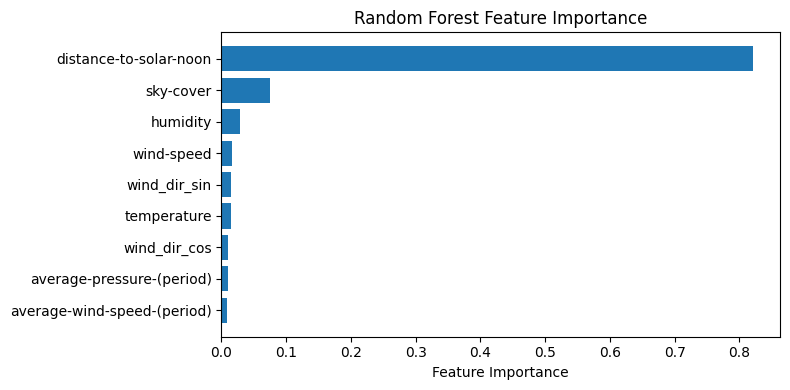

In [56]:
# Plotting Feature Importance according to Random Forest
importances_rf = best_rf.feature_importances_
feature_names = X_train.columns

# Create dataframe
feat_imp_rf = pd.DataFrame({"Feature": feature_names,
                            "Importance": importances_rf}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 4))
plt.barh(feat_imp_rf["Feature"], feat_imp_rf["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


## 3.2.4 Boosting Regressor Models

## 3.2.4.1 XGBoost Regressor

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Initialize the XGBRegressor with MAE objective
xgb_model = XGBRegressor(
    objective='reg:absoluteerror',
    n_jobs=-1,
    random_state=42,
    eval_metric='mae'
)

param_grid = {
    'learning_rate': [0.01, 0.02],
    'n_estimators': [1000, 1500],
    'max_depth': [4, 5, 6],
    'min_child_weight': [10, 20], 
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1, 0.5]
}

# Grid Search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the scaled data
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8], 'gamma': [0.1, 0.5], 'learning_rate': [0.01, 0.02], 'max_depth': [4, 5, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:absoluteerror'


In [58]:
# Report CV Performance
cv_mae = -grid_search_xgb.best_score_

print(f"Best CV MAE : {cv_mae:.4f}")
print("Best Parameters:", grid_search_xgb.best_params_)

Best CV MAE : 1330.1764
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 20, 'n_estimators': 1500, 'subsample': 0.8}


In [59]:
# Initialize and fit the model
best_xgb_model = grid_search_xgb.best_estimator_

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)  
mae_test = mean_absolute_error(y_test, y_test_pred)  

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

results["XGBoost"] = {
"Train MAE" : mae_train,
"Test MAE"  : mae_test,
"Train RMSE": rmse_train,
"Test RMSE" : rmse_test,
"Train R²" : r2_train,
"Test R²" : r2_test,
}

In [61]:
print("="*60)
print("XGBOOST REGRESSION – FINAL PERFORMANCE")
print("="*60)

print("\n[ Original-Scale Metrics ]")
print(f"Train MAE : {mae_train:.4f}")
print(f"Test MAE : {mae_test:.4f}")
print(f"Train RMSE : {rmse_train:.4f}")
print(f"Test RMSE : {rmse_test:.4f}")
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")


XGBOOST REGRESSION – FINAL PERFORMANCE

[ Original-Scale Metrics ]
Train MAE : 881.1193
Test MAE : 1492.8558
Train RMSE : 2145.1727
Test RMSE : 3427.9449
Train R² : 0.9568
Test R² : 0.8903


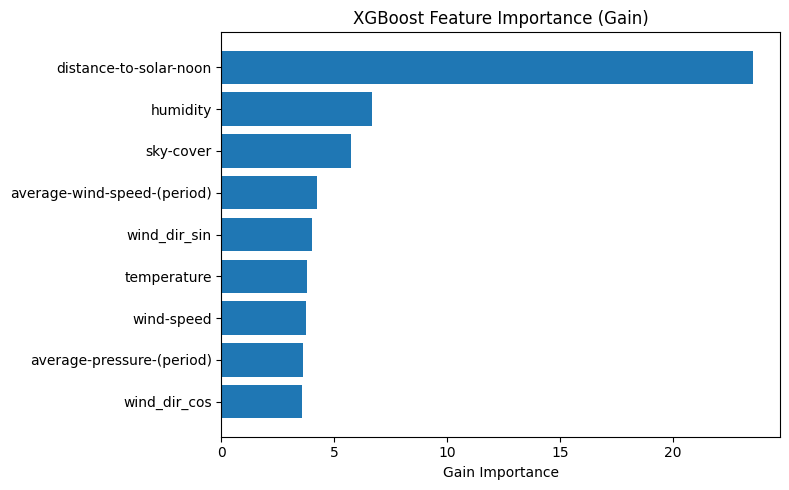

In [62]:
# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get gain-based importance
importance = best_xgb_model.get_booster().get_score(importance_type='gain')


importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Gain'])
plt.gca().invert_yaxis()
plt.xlabel("Gain Importance")
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()


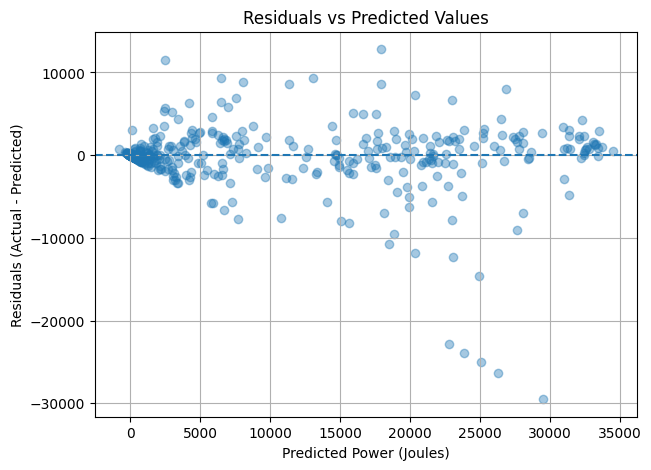

In [63]:
residuals = y_test - y_test_pred

plt.figure(figsize=(7,5))
plt.scatter(y_test_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Power (Joules)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()


The residuals are centered around zero, showing the model is generally unbiased and accurate for smaller values. The increasing spread at higher predicted values highlights areas where predictions are less precise, which is common with complex data

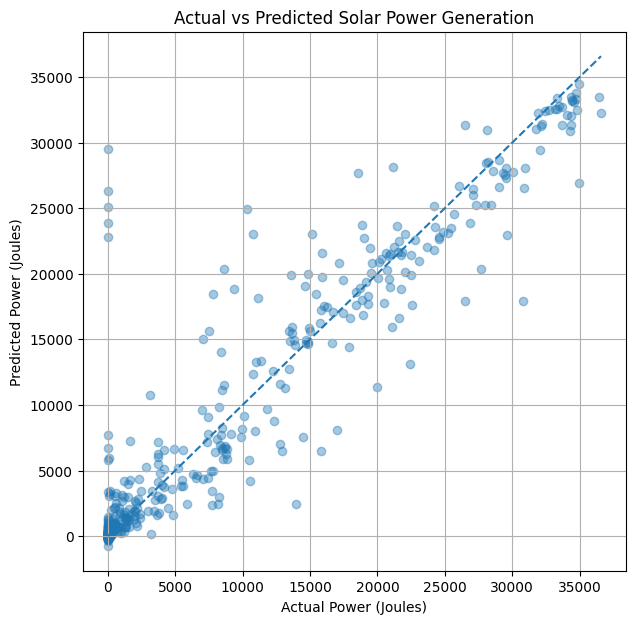

In [64]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle='--'
)
plt.xlabel("Actual Power (Joules)")
plt.ylabel("Predicted Power (Joules)")
plt.title("Actual vs Predicted Solar Power Generation")
plt.grid(True)
plt.show()


## 3.2.4.2 LightGradientBoosting Regressor

In [65]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(
    objective='regression_l1', 
    n_estimators=1500,          
    learning_rate=0.05,         
    n_jobs=-1,
    random_state=42
)

# Hyperparameter Grid
param_grid_lgb = {
   
    'num_leaves': [31, 63, 127], 
    'max_depth': [-1, 10, 20], 
    
    # Regularization to prevent overfitting on these larger trees
    'min_child_samples': [20, 50], 
    'colsample_bytree': [0.7, 0.9],
    
    # L1/L2 Regularization
    'reg_alpha': [1.0], 
    'reg_lambda': [1.0, 5.0]
}

# GridSearchCV
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    scoring='neg_mean_absolute_error',
    cv=3, 
    verbose=1,
    n_jobs=-1
)

# Fit on scaled training data
grid_search_lgb.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 2324, number of used features: 9
[LightGBM] [Info] Start training from score 410.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,estimator,LGBMRegressor...ndom_state=42)
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'max_depth': [-1, 10, ...], 'min_child_samples': [20, 50], 'num_leaves': [31, 63, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [66]:
# Report CV Performance
cv_mae = -grid_search_lgb.best_score_

print(f"Best CV MAE : {cv_mae:.4f}")
print("Best Parameters:", grid_search_lgb.best_params_)

Best CV MAE : 1295.9905
Best Parameters: {'colsample_bytree': 0.9, 'max_depth': 20, 'min_child_samples': 20, 'num_leaves': 31, 'reg_alpha': 1.0, 'reg_lambda': 1.0}


In [67]:
# Best model
best_lgb_model = grid_search_lgb.best_estimator_

In [68]:
# Predictions
y_train_pred_lgb = best_lgb_model.predict(X_train)
y_test_pred_lgb = best_lgb_model.predict(X_test)

# Metrics
mae_train_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
mae_test_lgb = mean_absolute_error(y_test, y_test_pred_lgb)
rmse_train_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
r2_train_lgb = r2_score(y_train, y_train_pred_lgb)
r2_test_lgb = r2_score(y_test, y_test_pred_lgb)

results["LightGBM"] = {
"Train MAE" : mae_train_lgb,
"Test MAE"  : mae_test_lgb,
"Train RMSE": rmse_train_lgb,
"Test RMSE" : rmse_test_lgb,
"Train R²" : r2_train_lgb,
"Test R²" : r2_test_lgb,
}


print("="*60)
print("LIGHTGBM REGRESSION – FINAL PERFORMANCE")
print("="*60)
print(f"Train MAE : {mae_train_lgb:.4f}")
print(f"Test MAE : {mae_test_lgb:.4f}")
print(f"Train RMSE : {rmse_train_lgb:.4f}")
print(f"Test RMSE : {rmse_test_lgb:.4f}")
print(f"Train R² : {r2_train_lgb:.4f}")
print(f"Test R² : {r2_test_lgb:.4f}")


LIGHTGBM REGRESSION – FINAL PERFORMANCE
Train MAE : 665.5891
Test MAE : 1514.2301
Train RMSE : 1928.8675
Test RMSE : 3465.9047
Train R² : 0.9650
Test R² : 0.8879


## 3.2.4.3 CatBoost Regressor

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [70]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

catboost_dir = "../models/"

# Initialize CatBoost
# We use 'Huber:delta=1.0' which is a hybrid of MAE and MSE.
# It is less sensitive to outliers than MSE, but smoother than MAE.
cb_model = CatBoostRegressor(
    loss_function='Huber:delta=1.0', 
    eval_metric='MAE',
    random_seed=42,
    verbose=0, 
    allow_writing_files=False
)

param_grid_cb = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03],
    'iterations': [500, 1000],
    # L2 Regularization (Ridge)
    'l2_leaf_reg': [3, 5, 7],
    'random_strength': [1, 2]
}

grid_search_cb = GridSearchCV(
    estimator=cb_model,
    param_grid=param_grid_cb,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on scaled training data
grid_search_cb.fit(X_train, y_train)

# Best model
best_cat_model = grid_search_cb.best_estimator_

print("Best Parameters:", grid_search_cb.best_params_)
print("Best CV MAE:", -grid_search_cb.best_score_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_strength': 1}
Best CV MAE: 6250.6561615409855


In [71]:
# Report CV Performance
cv_mae = -grid_search_cb.best_score_

print(f"Best CV MAE : {cv_mae:.4f}")
print("Best Parameters:", grid_search_cb.best_params_)

Best CV MAE : 6250.6562
Best Parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_strength': 1}


In [72]:

# Best model
best_cat_model = grid_search_cb.best_estimator_


In [73]:

# Predictions
y_train_pred_cat = best_cat_model.predict(X_train)
y_test_pred_cat = best_cat_model.predict(X_test)

# Metrics
mae_train_cat = mean_absolute_error(y_train, y_train_pred_cat)
mae_test_cat = mean_absolute_error(y_test, y_test_pred_cat)
rmse_train_cat = np.sqrt(mean_squared_error(y_train, y_train_pred_cat))
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_test_pred_cat))
r2_train_cat = r2_score(y_train, y_train_pred_cat)
r2_test_cat = r2_score(y_test, y_test_pred_cat)

results["CatBoost"] = {
"Train MAE" : mae_train_cat,
"Test MAE"  : mae_test_cat,
"Train RMSE": rmse_train_cat,
"Test RMSE" : rmse_test_cat,
"Train R²" : r2_train_cat,
"Test R²" : r2_test_cat,
}

print("="*60)
print("CatBoost REGRESSION – FINAL PERFORMANCE")
print("="*60)
print(f"Train MAE : {mae_train_cat:.4f}")
print(f"Test MAE : {mae_test_cat:.4f}")
print(f"Train RMSE : {rmse_train_cat:.4f}")
print(f"Test RMSE : {rmse_test_cat:.4f}")
print(f"Train R² : {r2_train_cat:.4f}")
print(f"Test R² : {r2_test_cat:.4f}")


CatBoost REGRESSION – FINAL PERFORMANCE
Train MAE : 6091.3473
Test MAE : 6087.8763
Train RMSE : 11071.1844
Test RMSE : 11111.8293
Train R² : -0.1515
Test R² : -0.1523


## 3.3 Model Metric Evaluation

In [74]:
results_df = pd.DataFrame(results)
display(results_df)

,LinearRegression,Ridge,Lasso,SVR,Decison_Tree,Random_Forest,XGBoost,LightGBM,CatBoost
Train MAE,6838.173521,6836.507595,6835.019227,1470.095237,990.338640,925.565540,881.119263,665.589131,6091.347265
Test MAE,7706.694211,7705.551439,7705.032338,3105.029760,1791.018041,1582.677351,1492.855835,1514.230130,6087.876250
Train RMSE,17858.309981,17851.786182,17843.505011,3281.223796,2566.426651,2121.835521,2145.172720,1928.867458,11071.184399
Test RMSE,22461.106603,22457.181345,22454.347243,8677.662835,4038.014772,3611.940413,3427.944865,3465.904745,11111.829335
Train R²,-1.996184,-1.993995,-1.991218,0.898851,0.938121,0.957703,0.956767,0.965046,-0.151532
Test R²,-3.708103,-3.706457,-3.705270,0.297269,0.847833,0.878251,0.890339,0.887897,-0.152271


All tree-based models perform much better than linear and SVR models, showing their ability to capture non-linear patterns in the data. Single decision trees have the weakest performance, with the lowest test R² (0.848) and the highest test errors (MAE ≈1791, RMSE ≈4038), indicating overfitting and poor generalization. Random Forest improves over a single tree by averaging multiple trees, reducing variance, and achieving better test performance (R² ≈0.878, MAE ≈1583, RMSE ≈3612).

Boosting models—XGBoost and LightGBM—deliver the strongest results. Both have high training R² (>0.95) and high test R² (≈0.89), showing they capture complex relationships while generalizing well. Their test MAE and RMSE are the lowest among all tree-based models, with **XGBoost** slightly better in test performance, while LightGBM shows slightly lower training errors. Overall, boosting ensembles provide the best balance between fitting the training data and generalizing to unseen data, making them the most effective choice for this dataset.

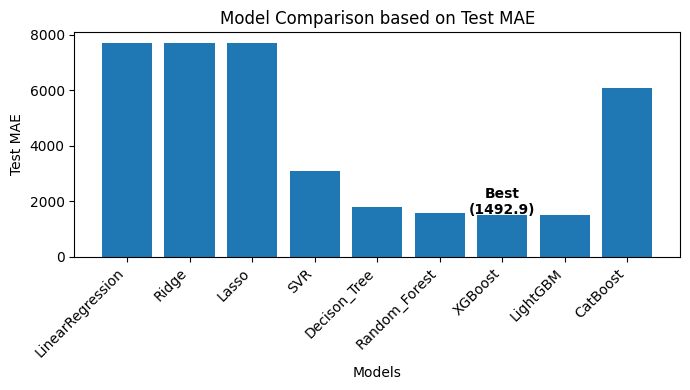

In [75]:
import matplotlib.pyplot as plt

# Model names and Test MAE values (from your results)
models = results_df.columns.tolist()
test_mae = results_df.loc['Test MAE'].tolist()

plt.figure(figsize=(7, 4))
plt.xticks(rotation=45, ha='right') 
plt.bar(models, test_mae)
plt.xlabel("Models")
plt.ylabel("Test MAE")
plt.title("Model Comparison based on Test MAE")

# Highlight best model
best_index = test_mae.index(min(test_mae))
plt.text(best_index, test_mae[best_index] + 30,
         f"Best\n({test_mae[best_index]:.1f})",
         ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 3.4 Model Dump

In [76]:
import joblib

# Create a dictionary of your best models to keep them organized
# Replace 'best_rf', 'best_xgb', etc. with the actual variable names of your winning models
models_to_save = {
    'decision_tree':best_dt,
    'random_forest': best_rf,          # Your best RF (MAE ~1582)
    'xgboost': best_xgb_model,           # Your best XGBoost (MAE ~1492)
    'lightgbm': best_lgb_model,               # Your best LightGBM (if you ran it)
    'catboost': best_cat_model
}

# Save the dictionary to a single file
joblib.dump(models_to_save, '../models/my_trained_models.pkl')

print("Models saved successfully to 'my_trained_models.pkl'")

Models saved successfully to 'my_trained_models.pkl'


In [77]:
import joblib

# Load the file
loaded_models = joblib.load('../models/my_trained_models.pkl')

# Extract the models back into variables
best_dt = loaded_models['decision_tree']
best_rf = loaded_models['random_forest']
best_xgb_model = loaded_models['xgboost']
best_lgb_model = loaded_models['lightgbm']
best_cat_model = loaded_models['catboost']

print("Models loaded. Ready to predict.")

# Example usage:
# y_pred = xgb_model.predict(X_test)

Models loaded. Ready to predict.
